<a href="https://colab.research.google.com/github/anushaharikrishnan/FaceMaskDetection/blob/third-traing-data/FACEMASKDETECTIONROUGH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
print(len(os.listdir('/content/drive/MyDrive/Face Mask Detection/dataset/with mask')))
print(len(os.listdir('/content/drive/MyDrive/Face Mask Detection/dataset/without mask')))

690
686


In [3]:
try:
  os.mkdir('/tmp/withmask-or-withoutmask')
  os.mkdir('/tmp/withmask-or-withoutmask/training')
  os.mkdir('/tmp/withmask-or-withoutmask/testing')
  os.mkdir('/tmp/withmask-or-withoutmask/training/withmask')
  os.mkdir('/tmp/withmask-or-withoutmask/training/withoutmask')
  os.mkdir('/tmp/withmask-or-withoutmask/testing/withmask')
  os.mkdir('/tmp/withmask-or-withoutmask/testing/withoutmask')

except OSError:
  pass

In [4]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]
  
  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)
  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)



MASK_SOURCE_DIR="/content/drive/MyDrive/Face Mask Detection/dataset/with mask/"
TRAINING_MASK_DIR="/tmp/withmask-or-withoutmask/training/withmask/"
TESTING_MASK_DIR="/tmp/withmask-or-withoutmask/testing/withmask/"
WITHOUTMASK_SOURCE_DIR="/content/drive/MyDrive/Face Mask Detection/dataset/without mask/"
TRAINING_WITHOUTMASK_DIR="/tmp/withmask-or-withoutmask/training/withoutmask/"
TESTING_WITHOUTMASK_DIR="/tmp/withmask-or-withoutmask/testing/withoutmask/"

split_size = .7

split_data(MASK_SOURCE_DIR,TRAINING_MASK_DIR,TESTING_MASK_DIR,split_size)
split_data(WITHOUTMASK_SOURCE_DIR,TRAINING_WITHOUTMASK_DIR,TESTING_WITHOUTMASK_DIR,split_size)

In [5]:
print(len(os.listdir('/tmp/withmask-or-withoutmask/training/withmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/testing/withmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/training/withoutmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/testing/withoutmask/')))

train_withmask_fnames=os.listdir(TRAINING_MASK_DIR)
train_withoutmask_fnames=os.listdir(TRAINING_WITHOUTMASK_DIR)
test_withmask_fnames=os.listdir(TESTING_MASK_DIR)
test_withoutmask_fnames=os.listdir(TESTING_WITHOUTMASK_DIR)

print(train_withmask_fnames[:10])
print(train_withoutmask_fnames[:10])
print(test_withmask_fnames[:10])
print(test_withoutmask_fnames[:10])

482
208
480
206
['augmented_image_266.jpg', '390-with-mask.jpg', 'augmented_image_122.jpg', '112-with-mask.jpg', 'augmented_image_134.jpg', 'augmented_image_211.jpg', 'augmented_image_189.jpg', 'augmented_image_208.jpg', 'augmented_image_200.jpg', 'augmented_image_179.jpg']
['augmented_image_143.jpg', '22.jpg', 'augmented_image_25.jpg', 'augmented_image_122.jpg', '441.jpg', 'augmented_image_134.jpg', 'augmented_image_211.jpg', 'augmented_image_189.jpg', 'augmented_image_33.jpg', 'augmented_image_208.jpg']
['augmented_image_143.jpg', 'augmented_image_25.jpg', 'augmented_image_33.jpg', 'augmented_image_173.jpg', '209-with-mask.jpg', 'augmented_image_252.jpg', '0-with-mask.jpg', '99-with-mask.jpg', '126-with-mask.jpg', '413-with-mask.jpg']
['67.jpg', '289.jpg', 'augmented_image_266.jpg', 'augmented_image_179.jpg', 'augmented_image_32.jpg', '39.jpg', '152.jpg', '110.jpg', '397.jpg', '28.jpg']


In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

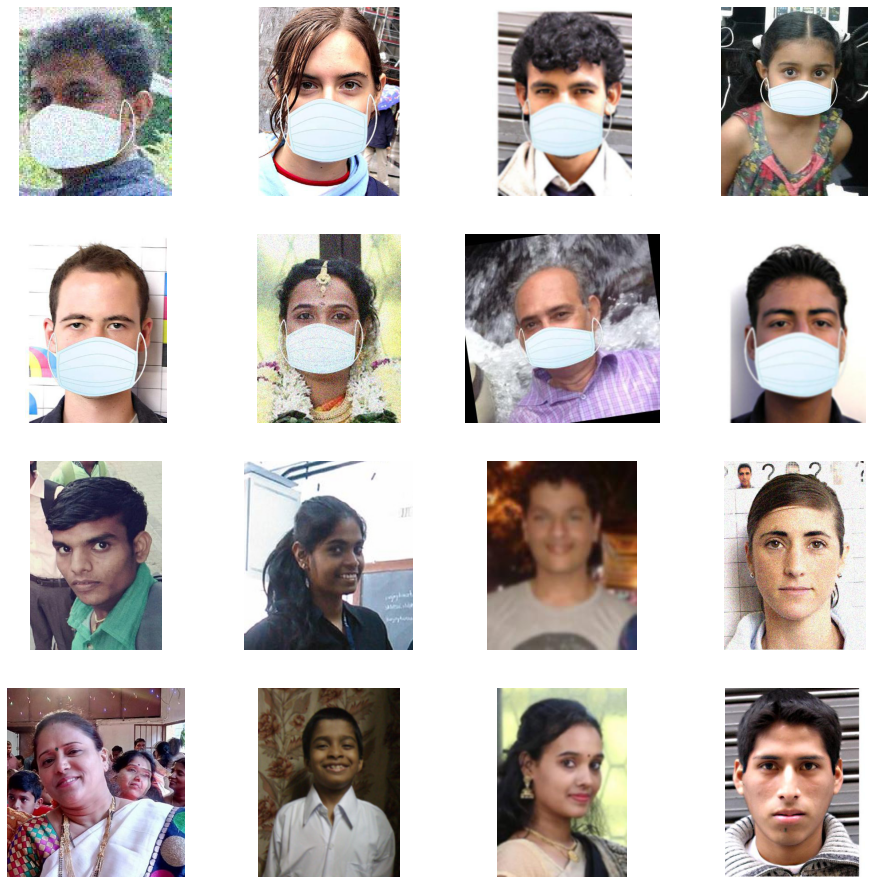

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(TRAINING_MASK_DIR, fname) 
                for fname in train_withmask_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(TRAINING_WITHOUTMASK_DIR, fname) 
                for fname in train_withoutmask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 645248)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

In [9]:
TRAINING_DIR = "/tmp/withmask-or-withoutmask/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    target_size=(300, 300))


VALIDATION_DIR = "/tmp/withmask-or-withoutmask/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.,
                                        rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=50,
                                                              class_mode='binary',
                                                              target_size=(300, 300))

Found 962 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [10]:
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)



history = model.fit(
      train_generator,
      steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=4,  # 1000 images = batch_size * steps
      verbose=2,
      callbacks=[callbacks])

Epoch 1/30
10/10 - 168s - loss: 43.5204 - accuracy: 0.5100 - val_loss: 0.6725 - val_accuracy: 0.6550
Epoch 2/30
10/10 - 148s - loss: 0.7025 - accuracy: 0.6104 - val_loss: 0.9495 - val_accuracy: 0.5000
Epoch 3/30
10/10 - 156s - loss: 3.5017 - accuracy: 0.5560 - val_loss: 1.4343 - val_accuracy: 0.4600
Epoch 4/30
10/10 - 149s - loss: 0.7748 - accuracy: 0.5173 - val_loss: 0.6812 - val_accuracy: 0.5350
Epoch 5/30
10/10 - 157s - loss: 1.1248 - accuracy: 0.5940 - val_loss: 0.6608 - val_accuracy: 0.4900
Epoch 6/30
10/10 - 149s - loss: 0.8177 - accuracy: 0.5563 - val_loss: 1.5997 - val_accuracy: 0.4850
Epoch 7/30
10/10 - 156s - loss: 1.0675 - accuracy: 0.5600 - val_loss: 0.6711 - val_accuracy: 0.6750
Epoch 8/30
10/10 - 156s - loss: 0.5882 - accuracy: 0.7200 - val_loss: 0.5919 - val_accuracy: 0.7100
Epoch 9/30
10/10 - 156s - loss: 0.7049 - accuracy: 0.6960 - val_loss: 0.5227 - val_accuracy: 0.7650
Epoch 10/30
10/10 - 157s - loss: 0.8860 - accuracy: 0.6126 - val_loss: 0.4630 - val_accuracy: 0.840

In [11]:
model.save("/content/drive/MyDrive/Colab Notebooks/face_mask_detection_model1")
model.save("/content/drive/MyDrive/Colab Notebooks/face_mask_detection_model1/my_h5_model.h5")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/face_mask_detection_model1/assets


<Figure size 432x288 with 0 Axes>

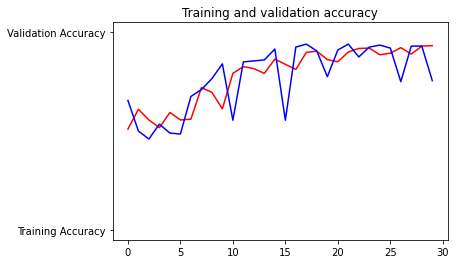

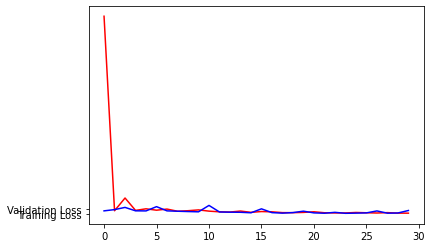

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [20]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a without mask")
  else:
    print(fn + " is with mask")


Saving withoutmask2.jpeg to withoutmask2.jpeg
[0.]
withoutmask2.jpeg is with mask


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


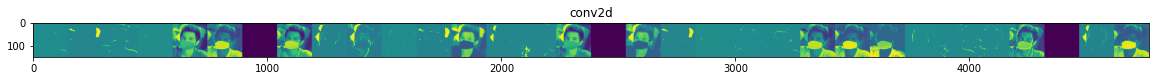

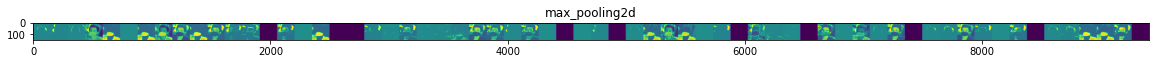

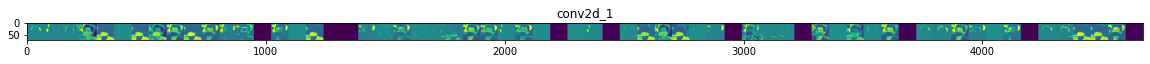

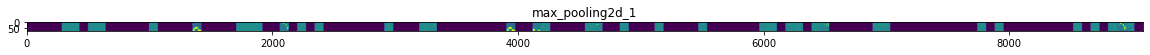

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
withmask_img_files = [os.path.join(TRAINING_MASK_DIR, f) for f in train_withmask_fnames]
withoutmask_img_files = [os.path.join(TRAINING_WITHOUTMASK_DIR, f) for f in train_withoutmask_fnames]

img_path = random.choice(withmask_img_files + withoutmask_img_files)
img = load_img(img_path, target_size=(300, 300))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 